# Week 5 — Categorical Data

In this notebook you'll learn to work with **categorical data**:
- **Contingency tables** (`pd.crosstab`), row/column proportions
- **Grouped summaries** (`.groupby()` + `agg`)
- **Proportions and percentages**
- **Chi-square test** intuition for independence
- **Practical**: correlation-style matrices and heatmaps for **categorical–categorical** relations (Cramér’s V)
- Explore relations in categorical variables

## Setup

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

sns.set_theme(context="notebook")

titanic = sns.load_dataset("titanic").dropna(subset=["sex", "class", "survived"])
tips = sns.load_dataset("tips")

titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 1. Contingency Tables

Used to summarize the relationship between two categorical variables. It displays the frequency distribution of the variables in a matrix format, allowing for easy comparison and analysis of their interactions.

Build a contingency table of sex vs survived using pd.crosstab
- Row proportions (normalize='index')
- Column proportions (normalize='columns')

> **Tips & Pitfalls**  
> • Prefer **row-wise proportions** for fair comparisons.  
> • Use **column-wise proportions** to see composition.  
> • Avoid interpreting raw counts alone.

survived,0,1
class,,
First,37.0,63.0
Second,52.7,47.3
Third,75.8,24.2


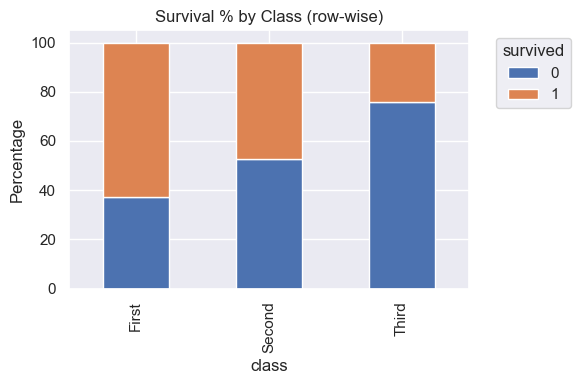

In [2]:

# Percentages (row-wise) + stacked bar chart
cls = pd.crosstab(titanic["class"], titanic["survived"], normalize="index")
display((cls*100).round(1))

ax = (cls*100).plot(kind="bar", stacked=True, figsize=(6,4))
ax.set_ylabel("Percentage")
ax.set_title("Survival % by Class (row-wise)")
plt.legend(title="survived", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## 2. Grouped Summaries — `.groupby()`

Groups data by one or more categorical variables
Useful to apply aggregation functions to compute summary statistics for each group.

Using tips, compute grouped summaries:

- mean total_bill and tip by sex and smoker
- tip rate = tip / total_bill -> group its mean

> **Tips & Pitfalls**  
> • Always report **n** with group means.  
> • Use **rates** (e.g., tip_rate) for fairness.  
> • Label aggregations clearly.

In [ ]:
# Lets create tip_rate column
tips["tip_rate"] = tips["tip"] / tips["total_bill"]

# Mean total_bill and tip by sex and smoker
grouped_means = tips.groupby(["sex", "smoker"], observed=True)[["total_bill", "tip"]].mean().reset_index()

# Mean tip rate by sex and smoker
tiprate_mean = tips.groupby(["sex", "smoker"], observed=True)["tip_rate"].mean().reset_index()

print("Mean total_bill and tip by sex and smoker:")
display(grouped_means)

print("\nMean tip rate by sex and smoker:")
display(tiprate_mean)


# as we can see, tip rate is a fairer target than raw tip amount

Mean total_bill and tip by sex and smoker:


,sex,smoker,total_bill,tip
0,Male,Yes,22.284500,3.051167
1,Male,No,19.791237,3.113402
2,Female,Yes,17.977879,2.931515
3,Female,No,18.105185,2.773519



Mean tip rate by sex and smoker:


,sex,smoker,tip_rate
0,Male,Yes,0.152771
1,Male,No,0.160669
2,Female,Yes,0.182150
3,Female,No,0.156921


## 3. Proportions and Percentages
Crosstab of class vs survived -> percentages (row-wise). Plot stacked bar chart.

> **Tips & Pitfalls**  
> • Convert counts to **percentages**.  
> • **Stacked bars** show composition; order categories logically.  
> • Consider adding exact labels.

Percentage of survival by class (row-wise):


survived,0,1
class,,
First,37.037037,62.962963
Second,52.717391,47.282609
Third,75.763747,24.236253


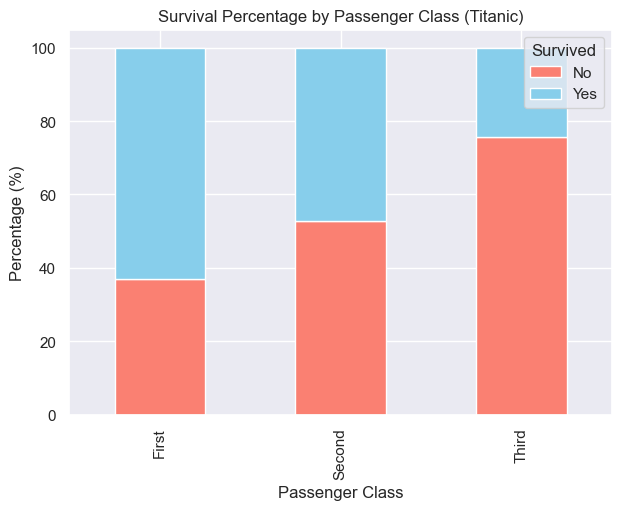

In [15]:
# Crosstab with row-wise normalization
ct_norm = pd.crosstab(
    titanic["class"],
    titanic["survived"],
    normalize='index'  # normalize per row (index)
) * 100  # convert to percentages

print("Percentage of survival by class (row-wise):")
display(ct_norm)

# Plot stacked bar chart
ct_norm.plot(
    kind="bar",
    stacked=True,
    figsize=(7, 5),
    color=["salmon", "skyblue"]
)

plt.title("Survival Percentage by Passenger Class (Titanic)")
plt.xlabel("Passenger Class")
plt.ylabel("Percentage (%)")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.show()


## 4. Chi-square Intuition
Chi'square is for independence between two categorical variables

Test for independence on sex vs survived

In [3]:

# Chi-square test (sex vs survived)
table = pd.crosstab(titanic["sex"], titanic["survived"])
chi2, p, dof, expected = chi2_contingency(table.values)
print(f"Chi-square = {chi2:.2f}, dof = {dof}, p-value = {p:.2e}")
print("Interpretation: p < 0.05 → reject independence; variables are associated.")


Chi-square = 260.72, dof = 1, p-value = 1.20e-58
Interpretation: p < 0.05 → reject independence; variables are associated.


## 5. Practical — Cramér’s V Matrix (Categorical–Categorical)
A measure of association between two categorical variables ranging from 0 to 1 (0 = no association, 1 = perfect association).

It defines the strength of association between two categorical variables based on the chi-square statistic.
Implement cramers_v and compute a heatmap over a set of categorical columns

> **Tips & Pitfalls**  
> • **Cramér’s V** ∈ [0,1]; higher means stronger association.  
> • Symmetric and table-size agnostic.  
> • Heatmaps highlight strongest/weakest links.

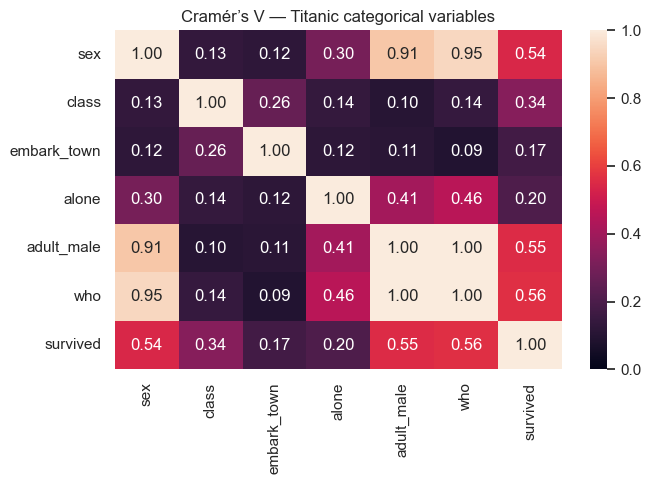

In [4]:

# Cramér’s V heatmap for categorical associations
def cramers_v(x, y):
    tbl = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(tbl)
    n = tbl.values.sum(); r, k = tbl.shape
    return np.sqrt(chi2 / (n * (min(r-1, k-1)))) if min(r-1, k-1) > 0 else np.nan

cat_cols = ["sex","class","embark_town","alone","adult_male","who","survived"]
cats = titanic[cat_cols].dropna()
V = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
for i in cat_cols:
    for j in cat_cols:
        V.loc[i,j] = cramers_v(cats[i], cats[j])

plt.figure(figsize=(7,5))
sns.heatmap(V.astype(float), annot=True, fmt=".2f", vmin=0, vmax=1)
plt.title("Cramér’s V — Titanic categorical variables")
plt.tight_layout()
plt.show()


## 6. Explore Relations — Gender vs Outcome
Survival rate by sex and class (pointplot) + short printed interpretation

> **Tips & Pitfalls**  
> • Compare **rates** (means of 0/1) rather than counts.  
> • Add **CIs** to bar/point plots.  
> • Watch for **confounding** (e.g., class × sex).

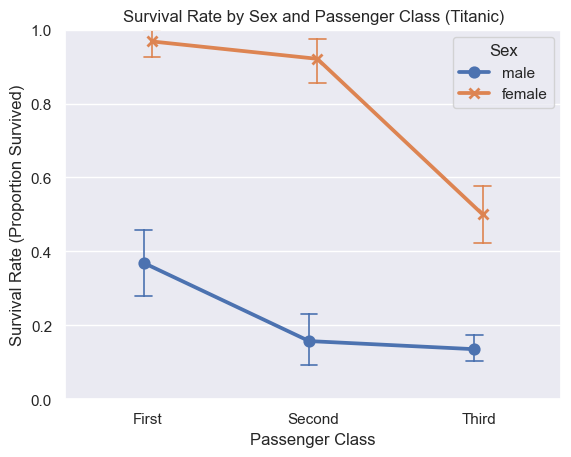

- Females show a much higher survival rate than males across all classes.
- First-class passengers have the highest survival probability, especially among women.
- Third-class males have the lowest survival rate — nearly 0.
- Even among the third-class passengers, the survival rate for females is higher than that of males.


In [19]:
sns.pointplot(
    data=titanic,
    x="class",
    y="survived",
    hue="sex",
    dodge=True,
    markers=["o", "x"],
    capsize=0.1,
    errorbar=("ci", 95), # it is the confidence interval       
    err_kws={"linewidth": 1.2}
)

plt.title("Survival Rate by Sex and Passenger Class (Titanic)")
plt.ylabel("Survival Rate (Proportion Survived)")
plt.xlabel("Passenger Class")
plt.ylim(0, 1)
plt.legend(title="Sex")
plt.show()

# Key insights:
print("- Females show a much higher survival rate than males across all classes.")
print("- First-class passengers have the highest survival probability, especially among women.")
print("- Third-class males have the lowest survival rate — nearly 0.")
print("- Even among the third-class passengers, the survival rate for females is higher than that of males.")


# 7. Practice — Categorical Data Challenge

**Your goal:** Apply *everything* learned so far about categorical data:
- Contingency tables and proportions
- Grouped summaries (`groupby`)
- Percentages and fair comparisons
- Chi-square test for independence
- Categorical–categorical effect sizes (Cramér’s V)
- Tell a brief data story based on your findings



### 7.1 Choose a dataset
Pick **one** to work with:
- `titanic` use `df = titanic.copy()`
- `tips`    use `df = tips.copy()`


In [ ]:
# we have chosen titanic dataset on this solution notebook, try with tips dataset as well


### 7.2 Contingency tables + row/column proportions
- Build **two** contingency tables using `pd.crosstab` for two pairs of categorical variables.
- For each, compute **row-wise** and **column-wise** proportions.


In [5]:

# Contingency tables and proportions (Titanic: sex × survived)
# Counts table answers: How many per (sex, outcome)?
ct = pd.crosstab(titanic["sex"], titanic["survived"])
display(ct)

# Row-wise proportions: Within each sex, what % survived vs not?
row_props = pd.crosstab(titanic["sex"], titanic["survived"], normalize="index").round(3)
display(row_props)

# Column-wise proportions: Among survivors vs non-survivors, what % are female/male?
col_props = pd.crosstab(titanic["sex"], titanic["survived"], normalize="columns").round(3)
display(col_props)


survived,0,1
sex,,
female,81,233
male,468,109


survived,0,1
sex,,
female,0.258,0.742
male,0.811,0.189


survived,0,1
sex,,
female,0.148,0.681
male,0.852,0.319



### 7.3 Grouped summaries
- Compute a grouped summary over **two categorical keys**, aggregating **at least two numeric targets** or one target with multiple aggregations.
- If you chose `tips` for example, compute **tip rate** = `tip / total_bill` and compare across groups.


In [7]:

# Grouped summaries on tips
# Means and counts by (sex, smoker)
g = tips.groupby(["sex", "smoker"], observed=True).agg(
    mean_total_bill=("total_bill", "mean"),
    mean_tip=("tip", "mean"),
    n=("tip", "size")
).round(2)
display(g)

# Tip rate is a fairer target than raw tip
tips = tips.assign(tip_rate=tips["tip"] / tips["total_bill"])
g_rate = tips.groupby(["sex","smoker"], observed=True)["tip_rate"].mean().round(3)
display(g_rate)


mean_total_bill  mean_tip   n
sex    smoker                               
Male   Yes               22.28      3.05  60
       No                19.79      3.11  97
Female Yes               17.98      2.93  33
       No                18.11      2.77  54

sex     smoker
Male    Yes       0.153
        No        0.161
Female  Yes       0.182
        No        0.157
Name: tip_rate, dtype: float64


### 7.4 Percentages plot
- Convert a crosstab into **percentages** (row-wise).  
- Produce a **stacked bar** chart to compare across groups.


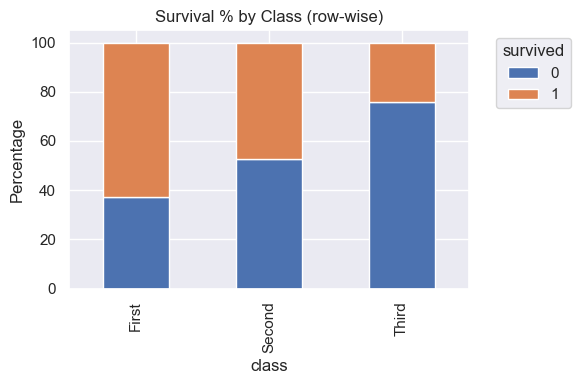

In [8]:

# Percentages stacked bar (class vs survived)
df = titanic.copy()
ct = pd.crosstab(df["class"], df["survived"], normalize="index")
ax = (ct*100).plot(kind="bar", stacked=True, figsize=(6,4))
ax.set_ylabel("Percentage"); ax.set_title("Survival % by Class (row-wise)")
plt.legend(title="survived", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout(); plt.show()



### 7.5 Chi-square test
- Test **independence** for one of your contingency tables.  
- State whether you would reject the null at α=0.05.


In [9]:

# Contingency tables and proportions (Titanic: sex × survived)
# Counts table answers: How many per (sex, outcome)?
ct = pd.crosstab(titanic["sex"], titanic["survived"])
display(ct)

# Row-wise proportions: Within each sex, what % survived vs not?
row_props = pd.crosstab(titanic["sex"], titanic["survived"], normalize="index").round(3)
display(row_props)

# Column-wise proportions: Among survivors vs non-survivors, what % are female/male?
col_props = pd.crosstab(titanic["sex"], titanic["survived"], normalize="columns").round(3)
display(col_props)


survived,0,1
sex,,
female,81,233
male,468,109


survived,0,1
sex,,
female,0.258,0.742
male,0.811,0.189


survived,0,1
sex,,
female,0.148,0.681
male,0.852,0.319



### 7.6 Cramér’s V matrix
- Build a **Cramér’s V** matrix for **5–7 categorical columns** and visualize with a **heatmap**.
- Briefly comment on the **strongest** and **weakest** associations.


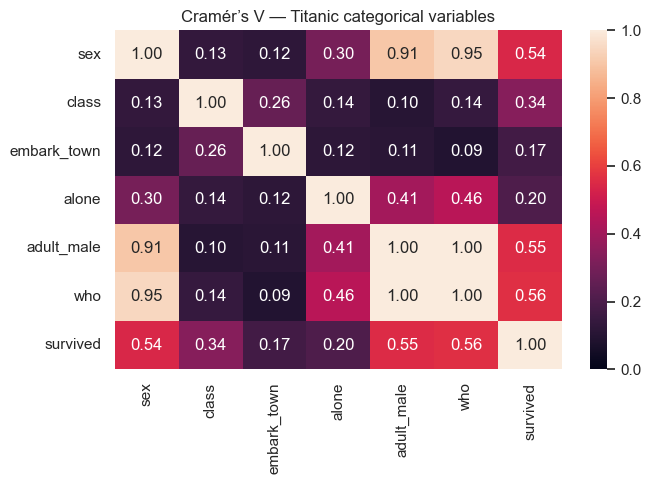

In [10]:

# Cramér’s V heatmap for categorical associations
def cramers_v(x, y):
    tbl = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(tbl)
    n = tbl.values.sum(); r, k = tbl.shape
    return np.sqrt(chi2 / (n * (min(r-1, k-1)))) if min(r-1, k-1) > 0 else np.nan

cat_cols = ["sex","class","embark_town","alone","adult_male","who","survived"]
cats = titanic[cat_cols].dropna()
V = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
for i in cat_cols:
    for j in cat_cols:
        V.loc[i,j] = cramers_v(cats[i], cats[j])

plt.figure(figsize=(7,5))
sns.heatmap(V.astype(float), annot=True, fmt=".2f", vmin=0, vmax=1)
plt.title("Cramér’s V — Titanic categorical variables")
plt.tight_layout()
plt.show()



### 7.7 Mini narrative (3–5 bullets)
Summarize your findings in clear, concise bullets. Mention at least one **limitation**.



**Your notes:**  
- ...  
- ...  
- ...


## Appendix — Quick Reference

**Contingency tables**
```
pd.crosstab(df['A'], df['B'])
pd.crosstab(df['A'], df['B'], normalize='index')    # row-wise
pd.crosstab(df['A'], df['B'], normalize='columns')  # column-wise
```

**Grouped summaries**
```
df.groupby(['g1','g2']).agg(mean_val=('x','mean'), n=('x','size'))
```

**Chi-square & Cramér’s V**
```
from scipy.stats import chi2_contingency
tbl = pd.crosstab(df['A'], df['B'])
chi2, p, dof, expected = chi2_contingency(tbl)

def cramers_v(x, y):
    tbl = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(tbl)
    n = tbl.values.sum()
    r, k = tbl.shape
    return np.sqrt(chi2 / (n * (min(r-1, k-1))))
```
